<a href="https://colab.research.google.com/github/ToniMarGar/Final_Project-Clothify/blob/main/Proyecto_final_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Descomprimir el archivo ZIP

In [59]:
import zipfile

# Ruta al archivo .zip y la carpeta de destino
archivo_zip = '/content/mini_dataset.zip'
carpeta_destino = '/content'

# Descomprimir el archivo .zip
with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_destino)


In [60]:
dataset_path = "/content/dataset"

2. Preprocesar las imágenes y preparar el dataset

In [56]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración del generador de datos
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Escalar valores de píxeles
    validation_split=0.2  # Dividir datos para entrenamiento y validación
)

# Rutas
dataset_path = "/content/dataset"
target_size = (299, 299)

# Generadores de datos
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    subset='training',
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=32,
    subset='validation',
    class_mode='categorical'
)


Found 26243 images belonging to 23 classes.
Found 6555 images belonging to 23 classes.



3. Cargar el modelo preentrenado y hacer Fine-Tuning

In [57]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Cargar el modelo preentrenado
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Añadir capas personalizadas para clasificación de prendas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
prenda_output = Dense(train_generator.num_classes, activation='softmax', name='prenda_output')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=prenda_output)

# Congelar las capas base
for layer in base_model.layers:
    layer.trainable = False

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(train_generator, validation_data=val_generator, epochs=20)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


821/821 ━━━━━━━━━━━━━━━━━━━━ 171s 181ms/step - accuracy: 0.4662 - loss: 1.6472 - val_accuracy: 0.5252 - val_loss: 1.4069
Epoch 2/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 126s 152ms/step - accuracy: 0.6899 - loss: 0.9052 - val_accuracy: 0.5396 - val_loss: 1.5008
Epoch 3/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 127s 154ms/step - accuracy: 0.7381 - loss: 0.7433 - val_accuracy: 0.5483 - val_loss: 1.5375
Epoch 4/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 141s 153ms/step - accuracy: 0.7743 - loss: 0.6448 - val_accuracy: 0.5324 - val_loss: 1.5997
Epoch 5/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 128s 155ms/step - accuracy: 0.8129 - loss: 0.5354 - val_accuracy: 0.5407 - val_loss: 1.6688
Epoch 6/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 141s 154ms/step - accuracy: 0.8327 - loss: 0.4801 - val_accuracy: 0.5533 - val_loss: 1.7437
Epoch 7/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 127s 153ms/step - accuracy: 0.8537 - loss: 0.4202 - val_accuracy: 0.5210 - val_loss: 1.8629
Epoch 8/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 148s 161ms/step - accuracy: 0.8654 - loss: 0.37

In [58]:
model.save('/content/modelo_finito.h5')

In [19]:
from tensorflow.keras.models import load_model
from keras.models import Model

model = load_model('/content/modelo_aumentado.h5')

embedding_model = Model(inputs=model.input,
                          outputs=model.get_layer('dense').output)

4. Extraer embeddings para las prendas

In [61]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
'''
# Desbloquear capas para extraer embeddings
for layer in base_model.layers:
    layer.trainable = True

# Crear un modelo para extraer embeddings
embedding_model = Model(inputs=base_model.input, outputs=x)
'''
# Función para procesar una carpeta y generar embeddings
def generate_embeddings(folder_path, model):
    embeddings = []
    image_names = []
    for root, _, files in os.walk(folder_path):  # Recorre subcarpetas
        for img_file in files:
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, img_file)
                img = image.load_img(img_path, target_size=(299, 299))
                img_array = image.img_to_array(img) / 255.0
                img_array = np.expand_dims(img_array, axis=0)
                embedding = model.predict(img_array)
                embeddings.append(embedding.flatten())
                relative_path = os.path.relpath(img_path, folder_path)  # Ruta relativa desde la carpeta raíz
                image_names.append(relative_path)
    return np.array(embeddings), image_names

# Generar embeddings
embeddings, image_names = generate_embeddings(dataset_path, embedding_model)
embeddings_dict = {name: embedding for name, embedding in zip(image_names, embeddings)}

# Exportar los embeddings a un archivo .npz
output_path = "embeddings.npz"
np.savez(output_path, embeddings=embeddings, image_names=image_names)

print(f"Embeddings exportados exitosamente a {output_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [ ]:
import numpy as np

output_path = "/content/embeddings.npz"
np.savez(output_path, embeddings=embeddings, image_names=image_names)

print(f"Embeddings exportados exitosamente a {output_path}")


Embeddings exportados exitosamente a /content/embeddings.npz


5. Encontrar prendas similares a la imagen del usuario

In [84]:
import os
import requests
from PIL import Image
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity

# Función para descargar una imagen desde una URL y abrirla con PIL
def load_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        return img
    else:
        raise ValueError(f"Error al descargar la imagen desde la URL: {response.status_code}")

# Función para encontrar las prendas más similares
def find_top_similar(query_embedding, embeddings_dict, top_n=3):
    similarities = []
    for filename, embedding in embeddings_dict.items():
        similarity = cosine_similarity([query_embedding], [embedding])[0][0]
        similarities.append((filename, similarity))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Generar embedding para una imagen desde una URL
query_image_url = 'https://dadati.es/content/images/thumbs/0023022_camisa-de-nino-en-cuadros-vichy-en-rosa-y-blanco_1000.jpeg'  # Cambia esta URL por la de tu imagen
query_image = load_image_from_url(query_image_url)

# Aquí puedes procesar la imagen (por ejemplo, redimensionarla o convertirla a un formato específico)
query_image_processed = query_image.resize((224, 224))  # Ajusta según lo que necesite tu modelo

# Guardar temporalmente la imagen procesada para usarla con el modelo (si es necesario)
query_image_path = '/tmp/query_image.jpg'
query_image_processed.save(query_image_path)

# Generar el embedding de la imagen de consulta
query_embedding, _ = generate_embeddings(os.path.dirname(query_image_path), embedding_model)

# Encontrar las prendas similares
top_similar_images = find_top_similar(query_embedding[0], embeddings_dict, top_n=3)
print(f"Prendas similares: {top_similar_images}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prendas similares: [('Sweaters_M/id_00001496.jpg', 0.83298814), ('Sweatshirts_Hoodies_M/id_00004641.jpg', 0.8244772), ('Shirts_Polos_M/id_00001005.jpg', 0.82347524)]


In [92]:
import os
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity

# Función para cargar una imagen desde una ruta local y abrirla con PIL
def load_image_from_path(image_path):
    if os.path.exists(image_path):
        img = Image.open(image_path)
        return img
    else:
        raise FileNotFoundError(f"La imagen no se encontró en la ruta especificada: {image_path}")

# Función para encontrar las prendas más similares
def find_top_similar(query_embedding, embeddings_dict, top_n=3):
    similarities = []
    for filename, embedding in embeddings_dict.items():
        similarity = cosine_similarity([query_embedding], [embedding])[0][0]
        similarities.append((filename, similarity))
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Ruta de la imagen de consulta (cambia esta ruta a la de tu archivo local)
query_image_path = '/content/para front/Shorts_W/id_00001235.jpg'

# Cargar la imagen desde la ruta local
query_image = load_image_from_path(query_image_path)

# Aquí puedes procesar la imagen (por ejemplo, redimensionarla o convertirla a un formato específico)
query_image_processed = query_image.resize((224, 224))  # Ajusta según lo que necesite tu modelo

# Guardar temporalmente la imagen procesada para usarla con el modelo (si es necesario)
query_image_temp_path = '/tmp/query_image.jpg'
query_image_processed.save(query_image_temp_path)

# Generar el embedding de la imagen de consulta
query_embedding, _ = generate_embeddings(os.path.dirname(query_image_temp_path), embedding_model)

# Encontrar las prendas similares
top_similar_images = find_top_similar(query_embedding[0], embeddings_dict, top_n=5)
print(f"Prendas similares: {top_similar_images}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prendas similares: [('Blouses_Shirts_W/id_00000093.jpg', 0.8215914), ('Blouses_Shirts_W/id_00000043.jpg', 0.80004454), ('Blouses_Shirts_W/id_00000028.jpg', 0.78403425), ('Shorts_W/id_00000748.jpg', 0.7769401), ('Blouses_Shirts_W/id_00000172.jpg', 0.7660639)]


7. Mostrar imágenes al usuario

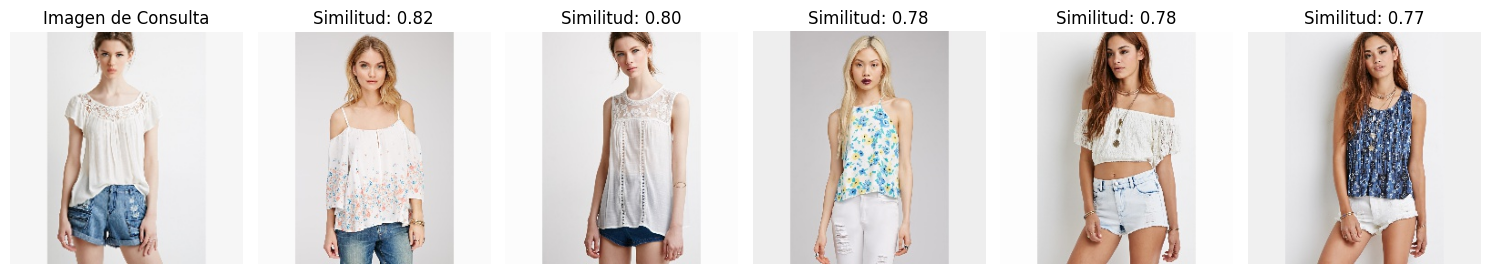

In [93]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_images(query_image, similar_images, dataset_path):
    fig, axes = plt.subplots(1, len(similar_images) + 1, figsize=(15, 5))

    # Mostrar imagen de consulta
    if isinstance(query_image, Image.Image):  # Verificar si es un objeto Image
        axes[0].imshow(query_image)
    else:  # Si no, asumir que es una ruta de archivo
        axes[0].imshow(Image.open(query_image))
    axes[0].axis('off')
    axes[0].set_title("Imagen de Consulta")

    # Mostrar imágenes similares
    for i, (filename, similarity) in enumerate(similar_images):
        img_path = os.path.join(dataset_path, filename)
        axes[i + 1].imshow(Image.open(img_path))
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f"Similitud: {similarity:.2f}")

    plt.tight_layout()
    plt.show()

# Mostrar las imágenes
# Asegúrate de que query_image sea un objeto Image o una ruta válida
show_images(query_image_processed, top_similar_images, dataset_path)


In [12]:
print(embeddings.shape)

(112, 1024)
